In [1881]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imutils
from imutils.perspective import four_point_transform

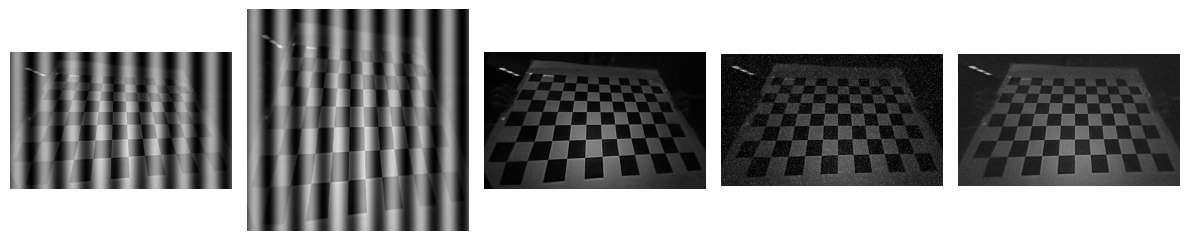

In [1882]:
Images = []
for i in range(1, 6):
         img = cv2.imread(f"./Images/Chessboard_{i}.png")
         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
         Images.append(img)
fig, ax = plt.subplots(1, 5, figsize=(12, 12))
for i, img in enumerate(Images):
         ax[i].imshow(img, cmap="gray"), ax[i].axis("off")
plt.tight_layout()
plt.show()

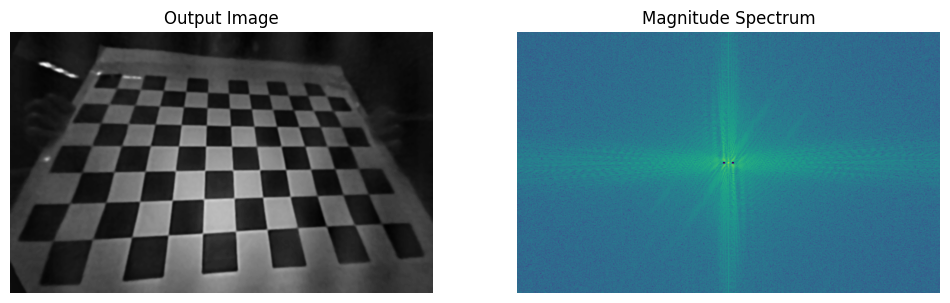

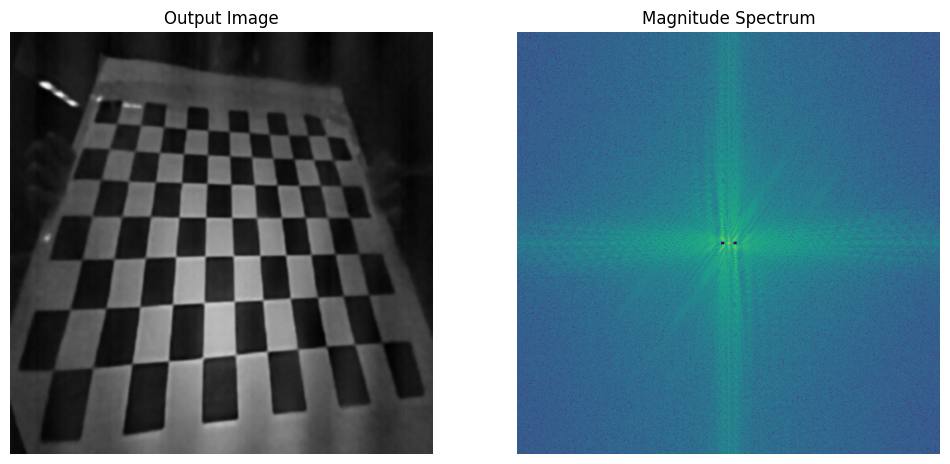

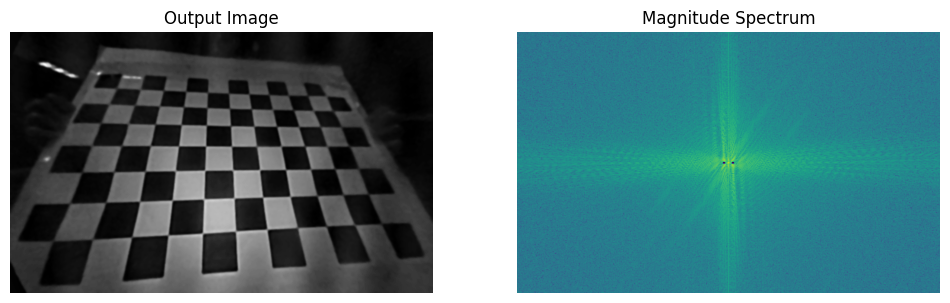

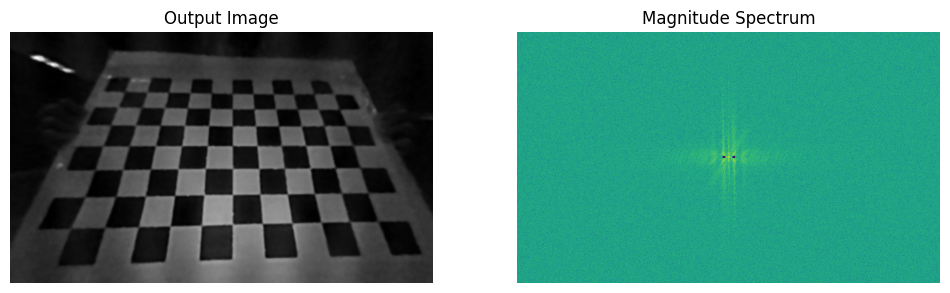

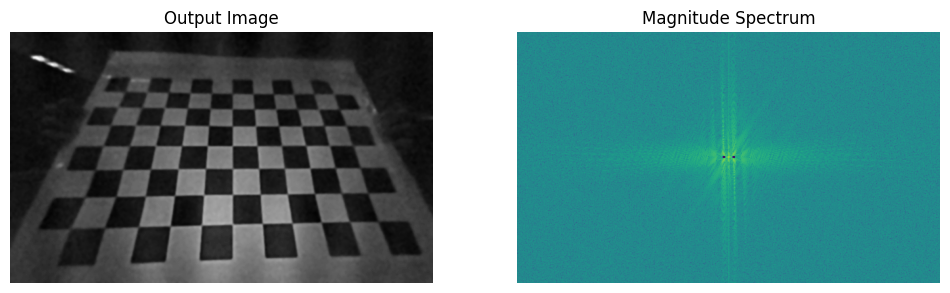

In [1883]:
sinus_filtered = []
for i, img in enumerate(Images):
         # Images.remove(img)
         dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
         fshift = np.fft.fftshift(dft)
         magnitude_spectrum = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1])+1)
         # if i==0 or i==1:
         #          ax[i].imshow(magnitude_spectrum, cmap="viridis"), ax[i].axis("off")
         is_max = np.zeros_like(fshift, dtype=bool)
         crow, ccol = int(fshift.shape[0]/2), int(fshift.shape[1]/2)
         is_max[crow-1:crow+2, ccol-9:ccol-5] = True
         is_max[crow-1:crow+2, ccol+6:ccol+10] = True
         filtered_fshift = np.copy(fshift)
         filtered_fshift[is_max] = 0

         filtered_magnitude = 20 * np.log(cv2.magnitude(filtered_fshift[:, :, 0], filtered_fshift[:, :, 1]) + 1)
         dft_filtered = np.fft.ifftshift(filtered_fshift)
         img_back = cv2.idft(dft_filtered)
         img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
         img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

         # lowpass = cv2.GaussianBlur(img_back, (5, 5), 0)
         # img_back = cv2.addWeighted(img_back, 2.0, lowpass, -0.5, 0)
         
         img_back = cv2.medianBlur(img_back, 5)
         img_back = cv2.GaussianBlur(img_back, (5,5), 0)
         
         fig, ax = plt.subplots(1, 2, figsize=(12, 6))
         ax[0].imshow(img_back, cmap='gray'), ax[0].set_title('Output Image'), ax[0].axis('off')   
         ax[1].imshow(filtered_magnitude, cmap='viridis'), ax[1].set_title('Magnitude Spectrum'), ax[1].axis('off')
         plt.show()
         
         sinus_filtered.append(img_back)
del Images
Images = sinus_filtered.copy()

### Canny detection and HoughLines

(104, 2)
(84, 2)
(108, 2)
(79, 2)
(84, 2)


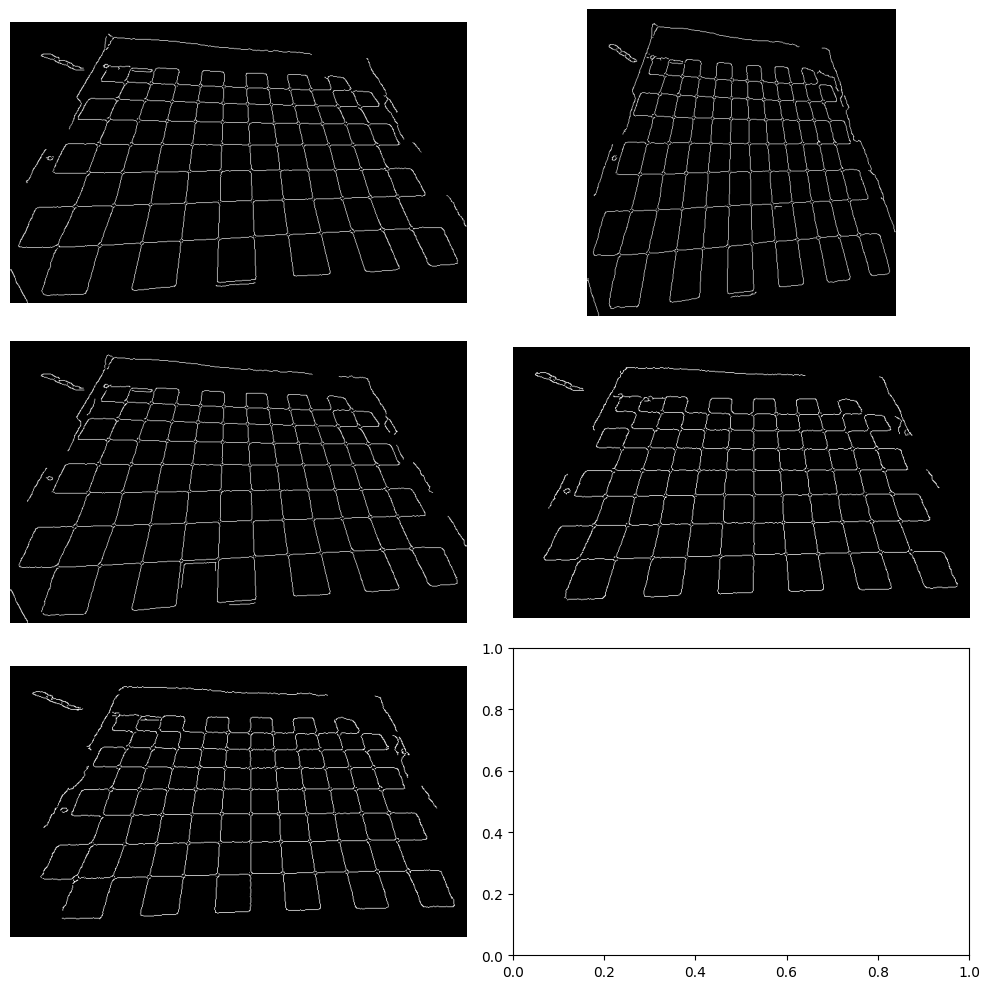

In [1884]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
lines = []
for i in range(len(Images)):
         # Images[2] = cv2.cvtColor(Images[2], cv2.COLOR_RGB2GRAY)
         Images[i] = cv2.GaussianBlur(Images[i], (5, 5), 0)     
         # Images[2] = cv2.threshold(Images[2], 28, 255, cv2.THRESH_BINARY)[1]
         # kernel = np.ones((3, 3), np.uint8)
         # Images[2] = cv2.dilate(Images[2], kernel, iterations=1)

         edge = cv2.Canny(Images[i], 20, 50, apertureSize=3)
         line = cv2.HoughLines(edge, 1, np.pi/180, 70)
         line = np.squeeze(line, axis=1)
         print(line.shape)
         lines.append(line)
         axs[i//2, i%2].imshow(edge, cmap='gray'), axs[i//2, i%2].axis('off')
plt.tight_layout()
plt.show()

### Draw line using cv2.line() and count horizontal lines and vertical lines

In [1885]:
def get_hori_vert(lines):
         hori, vert = [], []
         for line in lines:
                  rho, theta = line
                  if abs(theta-np.pi/2) < 0.2 or abs(theta-np.pi*3/2) < 0.2:  # horizontal: nằm ngang
                           hori.append(line)
                  else:   # vertical: nam doc
                           vert.append(line)
         return np.array(hori), np.array(vert)

In [ ]:
def draw_lines(img, lines):
    cnt_hori, cnt_vert = 0, 0
    for line in lines:
        rho, theta = line  # rho: distance from the origin (gốc toạ độ), theta: angle of normal vector
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        # draw lines: vertical and horizontal
        cv2.line(img, (x1, y1), (x2, y2), 255, 3)

### Remove noise lines

In [ ]:
def remove_noise_lines_hori(img, lines, num_lines=7):  
    mask = np.ones(lines.shape[0], dtype=bool)
    n_lines = lines.shape[0]
    eps_rho = 14
    eps_theta = 0.05
    while n_lines > num_lines:
        for i in range(lines.shape[0]):
            if mask[i] == False:
                continue
            rho, theta = lines[i,:]
            if (abs(rho) < 80 or abs(rho) > img.shape[0]- 30):  # delete lines near the edge image
                mask[i] = False
                n_lines -= 1
                continue
                # lines = np.delete(lines, np.where(lines == line)[0], axis=0)

            for j in range(i+1, lines.shape[0]):
                rho_, theta_ = lines[j,:]
                # remove noise lines: same rho and theta
                if abs(abs(rho)- abs(rho_)) < eps_rho and (abs(theta-theta_)% (np.pi)) < eps_theta and mask[j] == True:
                    mask[j] = False
                    n_lines -= 1
        eps_rho += 2
        eps_theta += 0.01
    return lines[mask]

def remove_noise_lines_vert(img, lines, num_lines=11):
    mask = np.ones(lines.shape[0], dtype=bool)
    n_lines = lines.shape[0]
    eps_rho = 14
    eps_theta = 0.05
    while n_lines > num_lines:
        for i in range(lines.shape[0]):
            if mask[i] == False:
                continue
            rho, theta = lines[i,:]
            if (abs(rho) < 0.25 * img.shape[1] or abs(rho) > img.shape[1]*0.67):  # delete lines near the edge image
                mask[i] = False
                n_lines -= 1
                continue
                # lines = np.delete(lines, np.where(lines == line)[0], axis=0)
                
            for j in range(i+1, lines.shape[0]):
                rho_, theta_ = lines[j,:]
                if mask[j] == False:
                    continue
                # remove noise lines: same rho and theta
                if abs(abs(rho)- abs(rho_)) < eps_rho and (abs(theta-theta_)< eps_theta 
                                                           or abs(abs(theta-theta_)-np.pi) < eps_theta):
                    mask[j] = False
                    n_lines -= 1
        eps_rho += 2
        eps_theta += 0.01
    return lines[mask]

### Count chessboard

Number of rows: 8, Number of columns: 11
Number of chessboards: 96
Number of rows: 8, Number of columns: 10
Number of chessboards: 88
Number of rows: 8, Number of columns: 11
Number of chessboards: 96
Number of rows: 8, Number of columns: 11
Number of chessboards: 96
Number of rows: 8, Number of columns: 11
Number of chessboards: 96


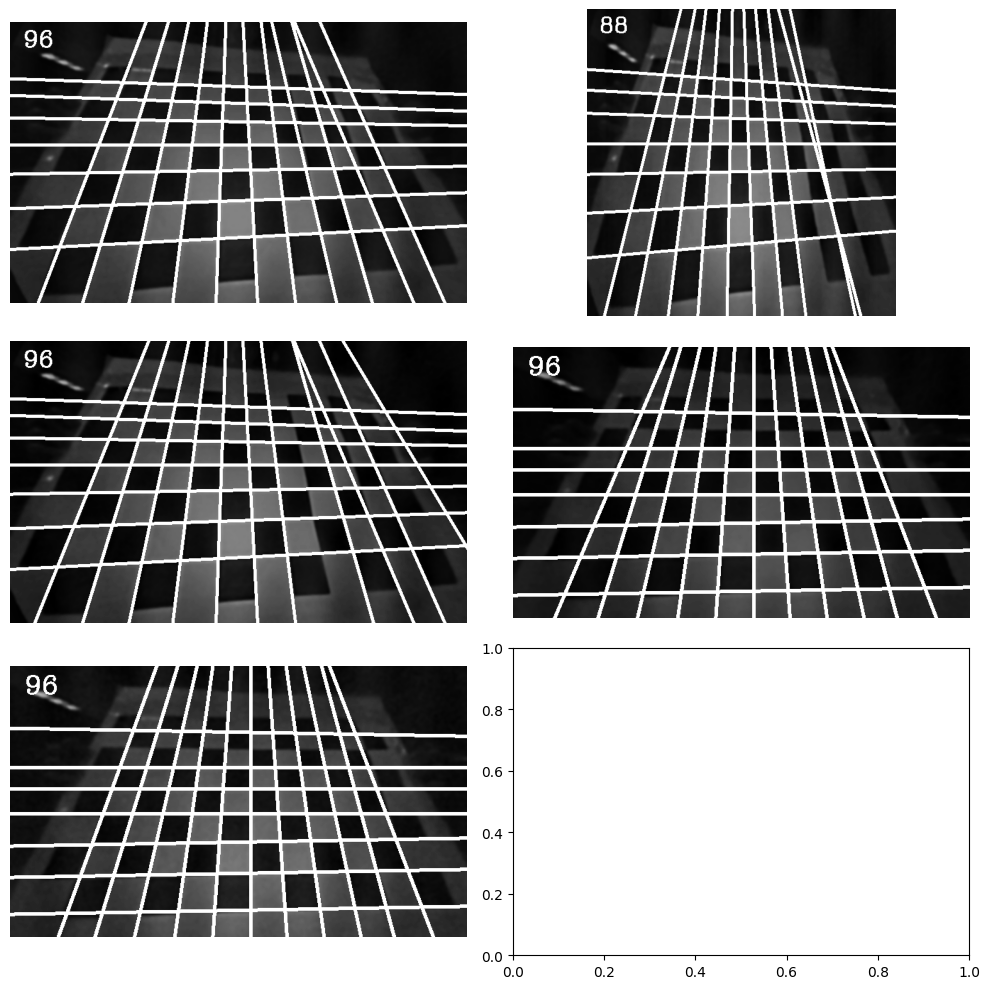

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i in range(len(Images)):
         hori, vert = get_hori_vert(lines[i])
         # print(hori.shape, vert.shape)
         hori = remove_noise_lines_hori(Images[i], hori)
         vert = remove_noise_lines_vert(Images[i], vert)
         print(f"Number of rows: {hori.shape[0]+1}, Number of columns: {vert.shape[0]}")
         lines[i] = np.concatenate((hori, vert), axis=0)
         draw_lines(Images[i], lines[i])
         print(f"Number of chessboards: {(hori.shape[0]+1)*(vert.shape[0]+1)}")
         cv2.putText(Images[i], f"{(hori.shape[0]+1)*(vert.shape[0]+1)}", (20, 40), cv2.FONT_HERSHEY_COMPLEX, 1.2, 255, 2)
         axs[i//2, i%2].imshow(Images[i], cmap="gray"), axs[i//2, i%2].axis('off')
         
plt.tight_layout()
plt.show()

         # contours, hierarchy = cv2.findContours((edge), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
         # contours = imutils.grab_contours((contours, hierarchy))
         # print(len(edge)) 
         # print(len(contours))  
         # Images[2] = cv2.drawContours(Images[2], contours, -1, (0, 255, 0), 2)

         # if len(contours) > 0:
         #      contours = sorted(contours, key=cv2.contourArea, reverse=True)  
         #      for con in contours:
         #           peri = cv2.arcLength(con, True)  # calculate the perimeter of the contour
         #           approx = cv2.approxPolyDP(con, 0.09 * peri, True)  # approximate the polygonal curve with the precision: 2% peri
         #           if 4 <= len(approx) <= 6 and cv2.contourArea(approx) > 25: 
         #                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
         #                Images[2] = cv2.drawContours(Images[2], approx, -1, color, 5)
 